数据挖掘互评作业三：分类与预测
所选数据集：Hotel booking demand
github地址：https://github.com/wafy0805/Report3

数据预处理

In [24]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import re
import sys
import csv
import os
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
#coding:utf-8

数据集一共有119390条数据，每条数据有32个不同字段
探索目标如下：
（1）基本情况：城市酒店和假日酒店预订需求和入住率比较；
（2）用户行为：提前预订时间、入住时长、预订间隔、餐食预订情况；
（3）一年中最佳预订酒店时间；
（4）利用Logistic预测酒店预订。

In [4]:
hotel_data = pd.read_csv('Desktop/hotel_bookings.csv')
hotel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

有上面分析得，存在缺失数据，字段及对应缺失值个数如下：

In [6]:
hotel_data.isnull().sum()[hotel_data.isnull().sum()!=0]

children         4
country        488
agent        16340
company     112593
dtype: int64

children很可能是因为没有儿童入住，所以可以用0填补缺失值；
country可以用众数取代；
agent和company缺失值过多，可以删除这两个字段

In [7]:
hotel_data['children']=hotel_data['children'].fillna(0)
hotel_data['country']=hotel_data['country'].fillna(value=hotel_data.country.mode()[0])
hotel_data.drop(['agent'],axis=1,inplace=True)
hotel_data.drop(['company'],axis=1,inplace=True)

In [34]:
#检查
print("The shape of data after drop nan:",hotel_data.shape)
hotel_data.isnull().sum()
#hotel_data.isnull().sum()[hotel_data.isnull().sum()!=0]

The shape of data after drop nan: (119390, 29)


is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status          

（1）基本情况：城市酒店和假日酒店预订需求和入住率比较；
     预订需求：城市酒店79330；假日酒店40060
     入住率分析如下

In [11]:
#两家酒店预定后实际入住
a=hotel_data[hotel_data['is_canceled']==0].groupby('hotel').is_canceled.count()
b=hotel_data[hotel_data['is_canceled']==1].groupby('hotel').is_canceled.count()
data=pd.DataFrame({'hotel':a.index,
                 '0':a.values,
                 '1':b.values
                  })
data['未取消比']=data['0']/(data['0']+data['1'])
data

,hotel,0,1,未取消比
0,City Hotel,46228,33102,0.582730
1,Resort Hotel,28938,11122,0.722366


由上表可知：入住率
城市酒店58.273% < 假日酒店72.237%

（2）用户行为：提前预订时间、入住时长、预订间隔、餐食预订情况

C:\Users\lijikun\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\lijikun\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\lijikun\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


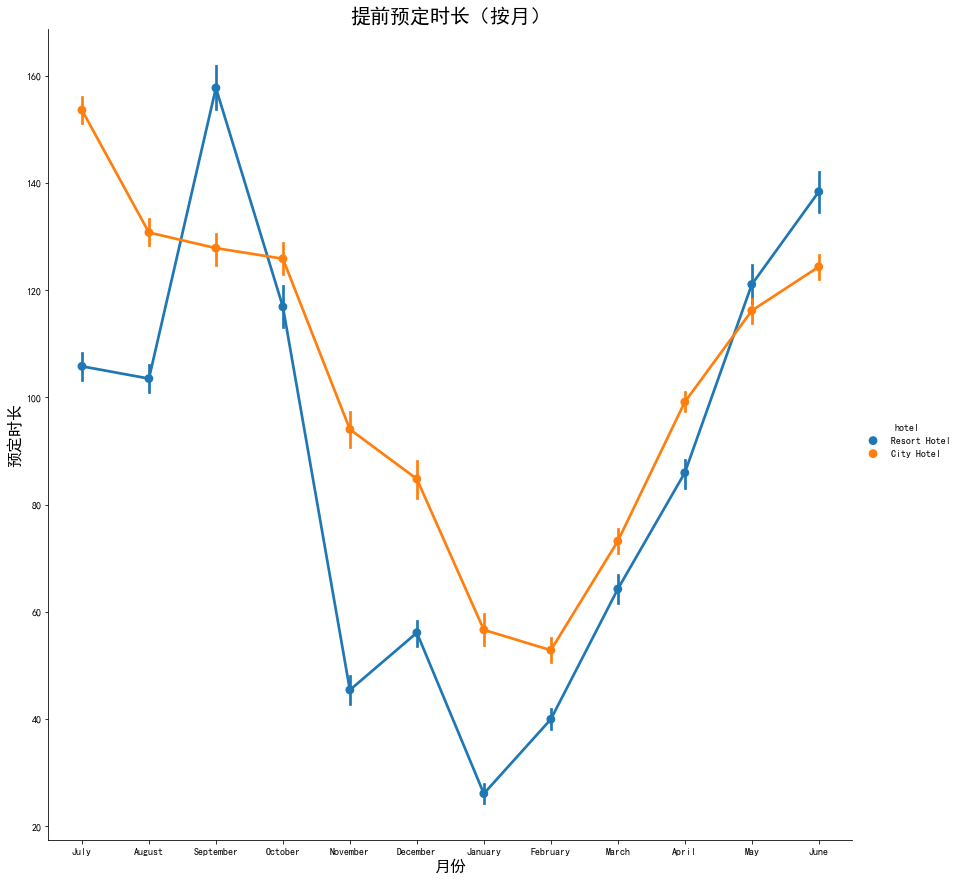

In [26]:
#按月提前预定时长
sns.factorplot(x='arrival_date_month',y='lead_time',hue='hotel',data=hotel_data,size=12)
plt.title("提前预定时长（按月）", fontsize=20)
plt.xlabel("月份", fontsize=16)
plt.ylabel("预定时长", fontsize=16)
plt.show()

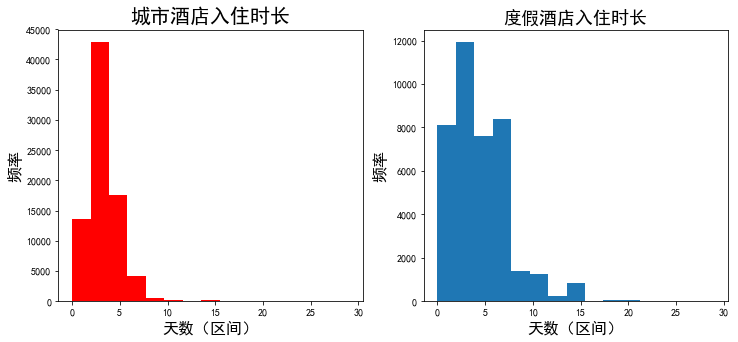

In [25]:
#入住时长
hotel_data['total_stay']=hotel_data['stays_in_weekend_nights']+hotel_data['stays_in_week_nights']
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
hotel_data.query("total_stay<30&hotel=='City Hotel'").total_stay.plot.hist(bins=15,color='r')
plt.title("城市酒店入住时长", fontsize=20)
plt.xlabel("天数（区间）", fontsize=16)
plt.ylabel("频率", fontsize=16)
plt.subplot(1,2,2)
hotel_data.query("total_stay<30&hotel=='Resort Hotel'").total_stay.plot.hist(bins=15)
plt.title("度假酒店入住时长", fontsize=18)
plt.xlabel("天数（区间）", fontsize=16)
plt.ylabel("频率", fontsize=16)
plt.show()

城市酒店入住时长绝大多数在五天以内；
度假酒店入住时长绝大多是在七天以内。

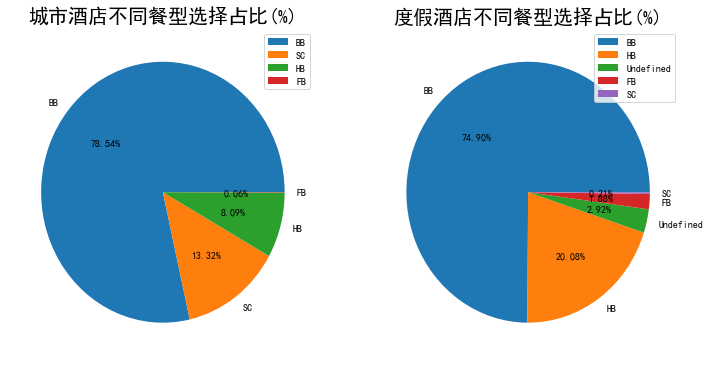

In [27]:
#餐型选择
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(hotel_data.query("hotel=='City Hotel'").meal.value_counts(),labels=hotel_data.query("hotel=='City Hotel'").meal.value_counts().index,autopct='%.2f%%')
plt.title("城市酒店不同餐型选择占比(%)", fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.pie(hotel_data.query("hotel=='Resort Hotel'").meal.value_counts(),labels=hotel_data.query("hotel=='Resort Hotel'").meal.value_counts().index,autopct='%.2f%%')
plt.title("度假酒店不同餐型选择占比(%)", fontsize=20)
plt.legend()
plt.show()

城市酒店与度假酒店餐型选择大体一致，大多数选择仅早餐（BB）

（3）一年中最佳预订酒店时间；

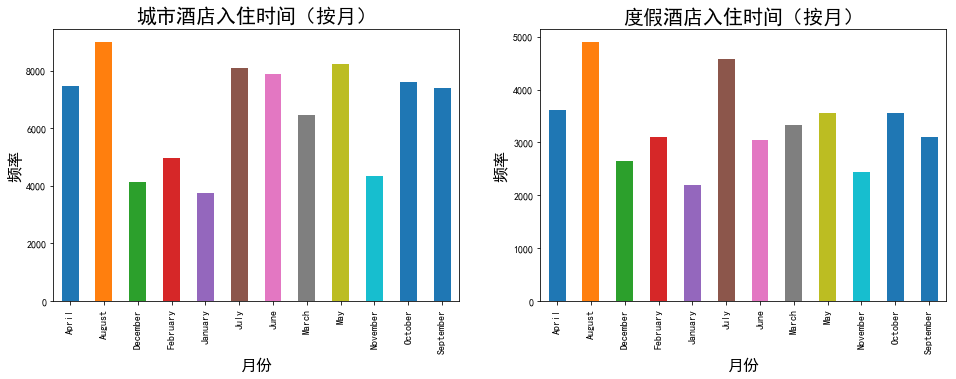

In [28]:
#入住时间(按月)
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
hotel_data.query("hotel=='City Hotel'").arrival_date_month.value_counts().sort_index().plot.bar()
plt.title("城市酒店入住时间（按月）", fontsize=20)
plt.xlabel("月份", fontsize=16)
plt.ylabel("频率", fontsize=16)
plt.subplot(1,2,2)
hotel_data.query("hotel=='Resort Hotel'").arrival_date_month.value_counts().sort_index().plot.bar()
plt.title("度假酒店入住时间（按月）", fontsize=20)
plt.xlabel("月份", fontsize=16)
plt.ylabel("频率", fontsize=16)
plt.show()

由上图可知：
城市酒店4-10月期间，酒店入住的频率相差不大，而 1、2、11、12月为入住淡季;
度假酒店7、8月份期间，为入住旺季，经分析可能是由于夏天为旅游旺季
因此预定酒店的最佳时间应在入住淡季，最好是在冬天11月到次年2月之间

（4）利用Logistic预测酒店预订

因为目标是要预测客户是否进行预订，所以可以去除对结果没有影响或影响不大的列，包括： hotel, agent, company,reservation_status_date；
由于agent, company两字段在前面已经去除，这里我们只需去掉 hotel，reservation_status_date这两个字段

In [ ]:
drop_columns=['hotel','reservation_status_date']
hotel_data.drop(inplace=True, axis=1, labels=drop_columns)

In [39]:
hotel_data.drop(['total_stay'],axis=1,inplace=True)

In [40]:
#检查之后的数据
print("The shape of data after drop nan:",hotel_data.shape)
hotel_data.isnull().sum()

The shape of data after drop nan: (119390, 28)


is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status          

将数据集划分为测试集和训练集

is_cancelled 表示客户是否预订了酒店，因此将其作为目标函数，其它字段作为特征

In [42]:
from sklearn.preprocessing import OneHotEncoder
#from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

因为数据同时具有数值特征和非数值特征，而Logistics Regression只能处理数值特征；因此，我去除掉其他的非数值特征字段

In [45]:
need_transfer=['meal','distribution_channel','reservation_status','country','arrival_date_month','market_segment',
 'deposit_type','customer_type', 'reserved_room_type','assigned_room_type' ]
hotel_data.drop(inplace=True, axis=1, labels=need_transfer)

In [46]:
#检查之后的数据
print("The shape of data after drop nan:",hotel_data.shape)
hotel_data.isnull().sum()

The shape of data after drop nan: (119390, 18)


is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
booking_changes                   0
days_in_waiting_list              0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
dtype: int64

将数据集的80%作为训练集，剩余的20%作为测试集

In [60]:
# X 为特征，y为标签
X = hotel_data.iloc[0:,1:]
y = hotel_data.iloc[0:,0]

In [61]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 17 columns):
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119390 non-null float64
babies                            119390 non-null int64
is_repeated_guest                 119390 non-null int64
previous_cancellations            119390 non-null int64
previous_bookings_not_canceled    119390 non-null int64
booking_changes                   119390 non-null int64
days_in_waiting_list              119390 non-null int64
adr                               119390 non-null float64
required_car_parking_spaces       119390 non-

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape

(95512, 17)

使用sklearn的LogisticsRegression进行训练和测试

训练

In [64]:
classifier = LogisticRegression(random_state = 0, max_iter=10000)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

测试集

In [65]:
y_pred = classifier.predict(X_test)
prediction = confusion_matrix(y_test, y_pred)
prediction

array([[13162,  1772],
       [ 4589,  4355]], dtype=int64)

In [66]:
accuracy = (prediction[0][0] + prediction[1][1]) * 100.0 / prediction.sum()
print("The final test accuracy is %.4f%%" % (accuracy))

The final test accuracy is 73.3604%


结果分析

In [ ]:
本次挖掘，我先在前期的数据预处理环节去除了缺失值过多的两个字段；
后续又在训练模型前去除了两个对于结果意义不大的两个字段；
又因为Logistics Regression只能处理数值特征，所以我去除掉里所有的非数值特征字段
在选取80%数据集作为训练集，20%数据集作为测试集的情况下Logistics预测的准确率为73.4%
我想，准确率不是特别高的原因可能在于非数值特征的字段没有纳入模型的原因